In [1]:
import numpy as np
import pandas as pd
import os
import random
from sklearn import preprocessing
from collections import deque
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, CuDNNLSTM, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

DIR = "C:/Users/Jackson/Documents/Data Science/CryptoCurrencies/"

dataset = DIR + "crypto_data/crypto_data.csv"

names = ["slug", "symbol", "name", "date","ranknow","open", "high", "low", "close", "volume", "market","close_ratio", "spread"]
data = pd.read_csv(dataset)

In [2]:
data["name"].value_counts()

Bitcoin                             2042
Litecoin                            2042
Namecoin                            2042
Novacoin                            2041
Peercoin                            2041
Feathercoin                         2037
Terracoin                           2027
BitBar                              2014
WorldCoin                           2003
Digitalcoin                         1999
GoldCoin                            1988
Primecoin                           1968
Anoncoin                            1948
XRP                                 1944
Ixcoin                              1939
Bullion                             1939
Megacoin                            1938
Freicoin                            1930
Infinitecoin                        1930
Quark                               1919
Phoenixcoin                         1907
Zetacoin                            1903
Fastcoin                            1876
Argentum                            1840
TagCoin         

In [3]:
data.describe()

,ranknow,open,high,low,close,volume,market,close_ratio,spread
count,942297.000000,9.422970e+05,9.422970e+05,9.422970e+05,9.422970e+05,9.422970e+05,9.422970e+05,942297.000000,9.422970e+05
mean,1000.170608,3.483522e+02,4.085930e+02,2.962526e+02,3.461018e+02,8.720390e+06,1.725060e+08,0.459499,1.123400e+02
std,587.575283,1.318436e+04,1.616386e+04,1.092931e+04,1.309822e+04,1.839803e+08,3.575590e+09,0.326160,6.783713e+03
min,1.000000,2.500000e-09,3.200000e-09,2.500000e-10,2.000000e-10,0.000000e+00,0.000000e+00,-1.000000,0.000000e+00
25%,465.000000,2.321000e-03,2.628000e-03,2.044000e-03,2.314000e-03,1.750000e+02,2.958100e+04,0.162900,0.000000e+00
50%,1072.000000,2.398300e-02,2.680200e-02,2.143700e-02,2.389200e-02,4.278000e+03,5.227960e+05,0.432400,0.000000e+00
75%,1484.000000,2.268600e-01,2.508940e-01,2.043910e-01,2.259340e-01,1.190900e+05,6.874647e+06,0.745800,3.000000e-02
max,2072.000000,2.298390e+06,2.926100e+06,2.030590e+06,2.300740e+06,2.384090e+10,3.265020e+11,1.000000,1.770563e+06


In [4]:
data.shape
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942297 entries, 0 to 942296
Data columns (total 13 columns):
slug           942297 non-null object
symbol         942297 non-null object
name           942297 non-null object
date           942297 non-null object
ranknow        942297 non-null int64
open           942297 non-null float64
high           942297 non-null float64
low            942297 non-null float64
close          942297 non-null float64
volume         942297 non-null float64
market         942297 non-null float64
close_ratio    942297 non-null float64
spread         942297 non-null float64
dtypes: float64(8), int64(1), object(4)
memory usage: 93.5+ MB


In [5]:
#convert data types into correct formats
data["date"] = pd.to_datetime(data["date"])
data["market_billion"] = data["market"]/1e9
data["volume_million"] = data["volume"]/1e6

In [6]:
#convert to wideformat
wide_format = data.groupby(["date", "name"])["close"].last().unstack()
wide_format.head()

name,0chain,0x,0xBitcoin,0xcert,1World,2GIVE,300 Token,42-coin,4NEW,808Coin,...,imbrex,indaHash,nDEX,nUSD,savedroid,smARTOFGIVING,ugChain,vSlice,vSportCoin,wys Token
date,,,,,,,,,,,,,,,,,,,,,
2013-04-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
wide_format.describe()

name,0chain,0x,0xBitcoin,0xcert,1World,2GIVE,300 Token,42-coin,4NEW,808Coin,...,imbrex,indaHash,nDEX,nUSD,savedroid,smARTOFGIVING,ugChain,vSlice,vSportCoin,wys Token
count,151.000000,471.000000,179.000000,141.000000,254.000000,928.000000,479.000000,1767.000000,100.000000,8.570000e+02,...,419.000000,310.000000,52.000000,140.000000,109.000000,70.000000,321.000000,704.000000,79.000000,128.000000
mean,0.226043,0.755702,0.752177,0.011381,0.157538,0.004351,431.592610,16060.952332,0.038936,3.809788e-04,...,0.360473,0.045366,0.000025,0.993826,0.000855,0.104977,0.037280,0.229741,0.003067,0.021298
std,0.127666,0.456668,0.584787,0.009870,0.069175,0.005247,248.351083,46399.765311,0.017472,6.091416e-04,...,0.403260,0.069530,0.000010,0.007638,0.000292,0.017982,0.035255,0.288677,0.000743,0.013511
min,0.077287,0.170806,0.271742,0.001886,0.057250,0.000098,112.650000,20.720000,0.018916,2.200000e-07,...,0.047550,0.003004,0.000010,0.956075,0.000365,0.048180,0.002447,0.002028,0.001306,0.004697
25%,0.142757,0.366899,0.428322,0.004956,0.102088,0.000407,216.820000,500.080000,0.025860,3.800000e-05,...,0.138685,0.007147,0.000017,0.990096,0.000698,0.097861,0.009387,0.056776,0.002909,0.010187
50%,0.187000,0.706612,0.558985,0.007750,0.145004,0.003415,380.050000,1648.150000,0.036045,1.470000e-04,...,0.225433,0.015522,0.000025,0.994899,0.000808,0.109565,0.029804,0.104084,0.003079,0.018399
75%,0.263088,0.993217,0.874518,0.011754,0.200193,0.005782,576.615000,19514.850000,0.042046,3.900000e-04,...,0.395246,0.054893,0.000032,0.999413,0.000942,0.119500,0.048961,0.243430,0.003708,0.027934
max,0.619802,2.370000,4.330000,0.039857,0.443498,0.039473,1461.650000,793273.000000,0.112169,4.877000e-03,...,3.210000,0.614736,0.000044,1.010000,0.001890,0.127035,0.178324,1.170000,0.004275,0.060287


In [8]:
sns.set()
%matplotlib inline
sns.set(rc={"figure.figsize": (12,6)})
pd.options.display.float_format = "{:.2f}".format
sns.set_style('whitegrid')
sns.set_palette("Paired")

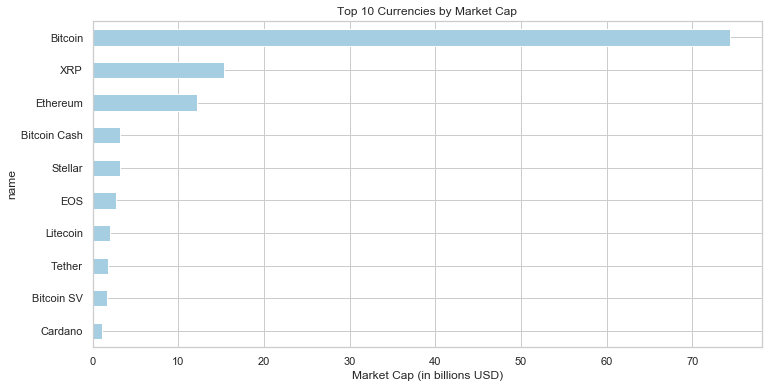

In [9]:
ax = data.groupby(["name"])["market_billion"].last().sort_values(ascending=False).head(10).sort_values().plot(kind="barh");
ax.set_xlabel("Market Cap (in billions USD)");
ax.set_title("Top 10 Currencies by Market Cap");

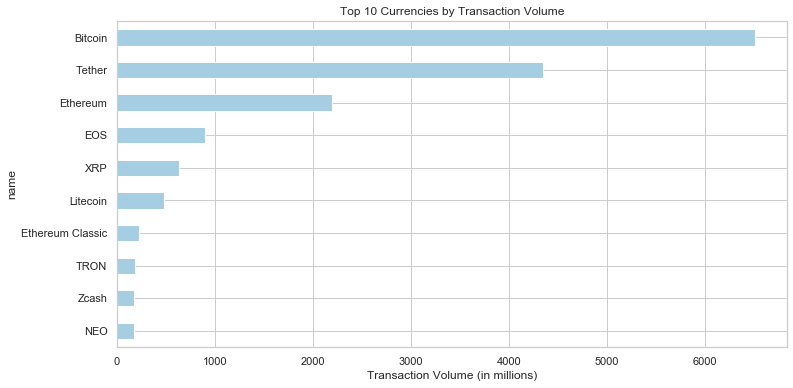

In [10]:
ax = data.groupby(["name"])["volume_million"].last().sort_values(ascending=False).head(10).sort_values().plot(kind="barh");
ax.set_xlabel("Transaction Volume (in millions)");
ax.set_title("Top 10 Currencies by Transaction Volume");

In [11]:
#defining the top 5 currencies

top_5_currency_names = data.groupby(["name"])["market"].last().sort_values(ascending = False).head(5).index
data_top_5_currencies = data[data["name"].isin(top_5_currency_names)]

data_top_5_currencies.describe()

,ranknow,open,high,low,close,volume,market,close_ratio,spread,market_billion,volume_million
count,7270.00,7270.00,7270.00,7270.00,7270.00,7270.00,7270.00,7270.00,7270.00,7270.00,7270.00
mean,2.52,740.32,765.00,712.85,740.76,660391060.08,17117085462.77,0.50,52.15,17.12,660.39
std,1.29,2084.06,2157.86,1995.59,2084.30,1837336230.54,36759178514.94,0.31,204.62,36.76,1837.34
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,0.01,0.01,0.01,0.01,369596.75,206042906.75,0.23,0.00,0.21,0.37
50%,2.00,1.25,1.35,1.17,1.25,23354500.00,3679884846.50,0.50,0.17,3.68,23.35
75%,4.00,451.73,462.62,443.39,451.91,319923000.00,13039122948.75,0.78,18.99,13.04,319.92
max,5.00,19475.80,20089.00,18974.10,19497.40,23840899072.00,326502000000.00,1.00,4110.40,326.50,23840.90


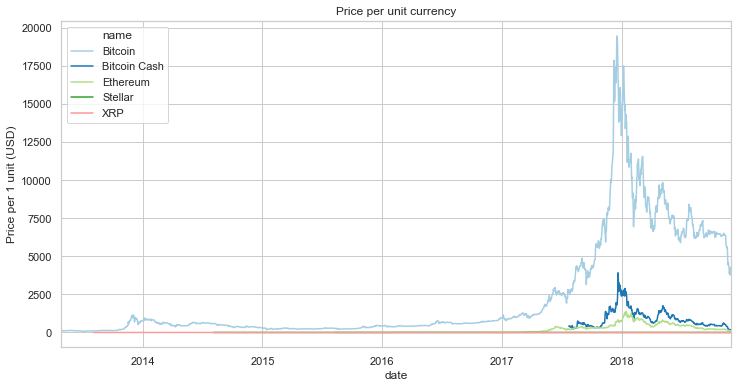

In [12]:
ax = data_top_5_currencies.groupby(["date","name"])["close"].mean().unstack().plot();
ax.set_ylabel("Price per 1 unit (USD)");
plt.title("Price per unit currency");

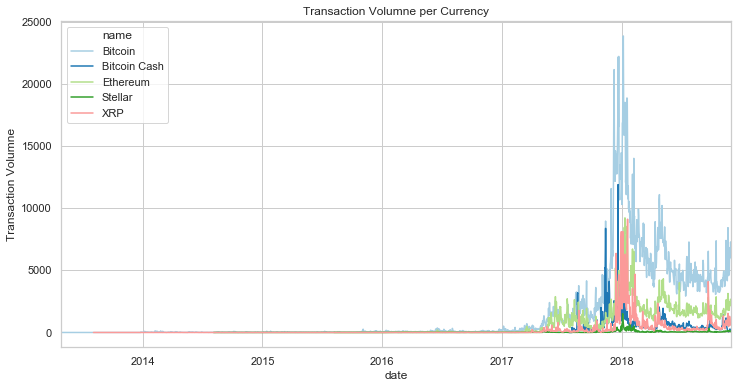

In [13]:
ax = data_top_5_currencies.groupby(["date","name"])["volume_million"].mean().unstack().plot();
ax.set_ylabel("Transaction Volumne");
plt.title("Transaction Volumne per Currency");

Text(0.5, 1.0, 'Price per unit of currency (from 2017)')

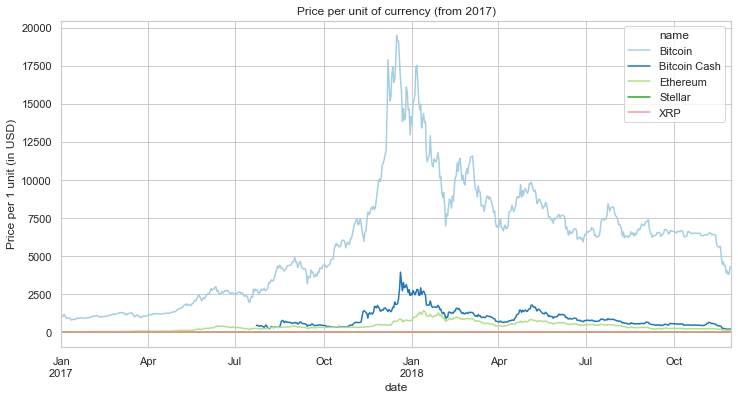

In [14]:
ax = data_top_5_currencies[data_top_5_currencies.date.dt.year >= 2017].groupby(["date","name"])["close"].mean().unstack().plot();
ax.set_ylabel("Price per 1 unit (in USD)");
plt.title("Price per unit of currency (from 2017)")

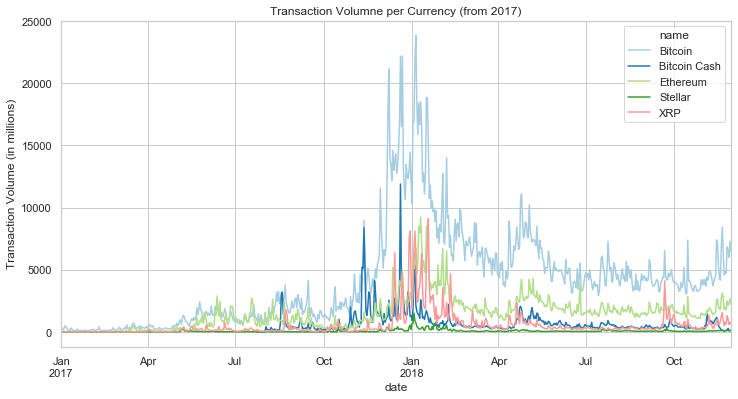

In [15]:
ax = data_top_5_currencies[data_top_5_currencies.date.dt.year >= 2017].groupby(["date","name"])["volume_million"].mean().unstack().plot();
ax.set_ylabel("Transaction Volume (in millions)");
plt.title("Transaction Volumne per Currency (from 2017)");

Text(0.5, 1.0, 'Price per unit of currency (from 2018)')

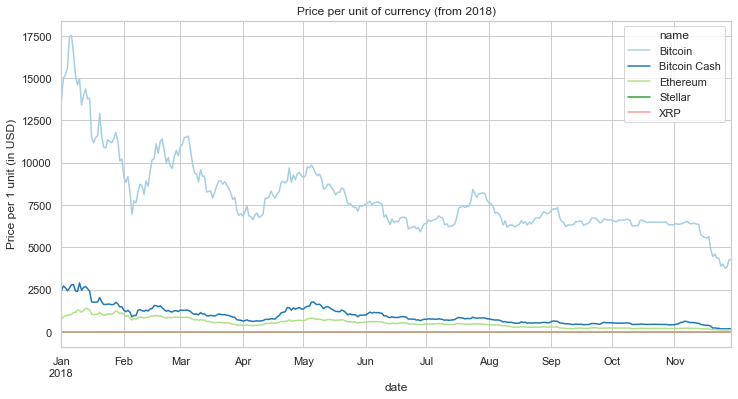

In [16]:
ax = data_top_5_currencies[data_top_5_currencies.date.dt.year >= 2018].groupby(["date","name"])["close"].mean().unstack().plot();
ax.set_ylabel("Price per 1 unit (in USD)");
plt.title("Price per unit of currency (from 2018)")

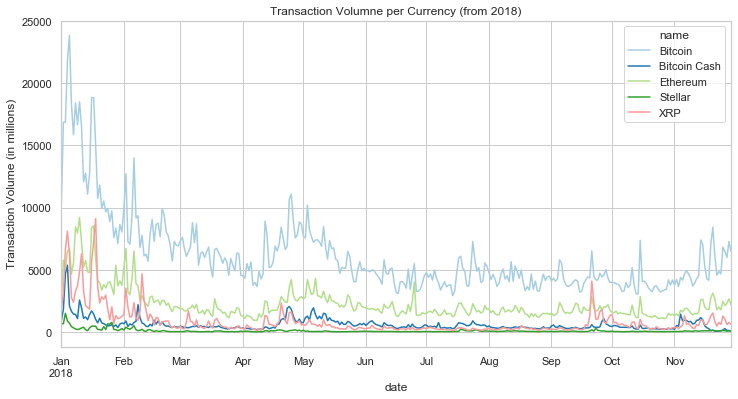

In [17]:
ax = data_top_5_currencies[data_top_5_currencies.date.dt.year >= 2018].groupby(["date","name"])["volume_million"].mean().unstack().plot();
ax.set_ylabel("Transaction Volume (in millions)");
plt.title("Transaction Volumne per Currency (from 2018)");

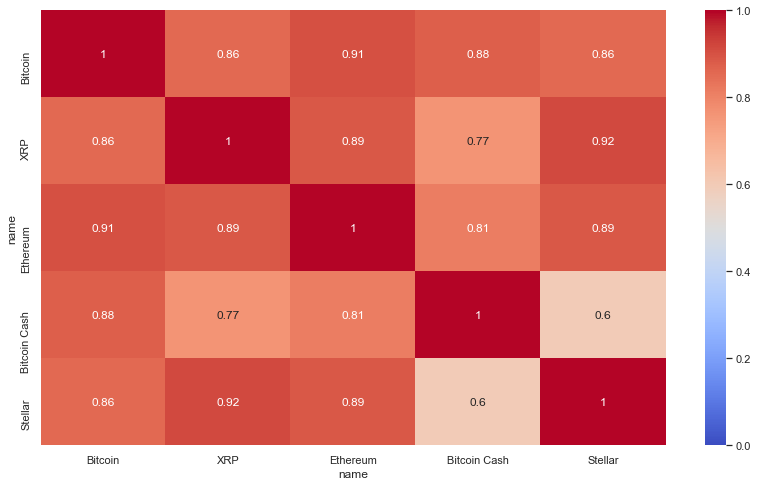

In [18]:
plt.figure(figsize=(14,8))
sns.heatmap(wide_format[top_5_currency_names].corr(), vmin = 0, vmax = 1, cmap='coolwarm', annot = True);

In [19]:
def plot_roi(amount,df):
    ((amount / df.iloc[0]) * df).plot(figsize=(12,8))
    plt.ylabel("Price per 1 unit (in USD)")

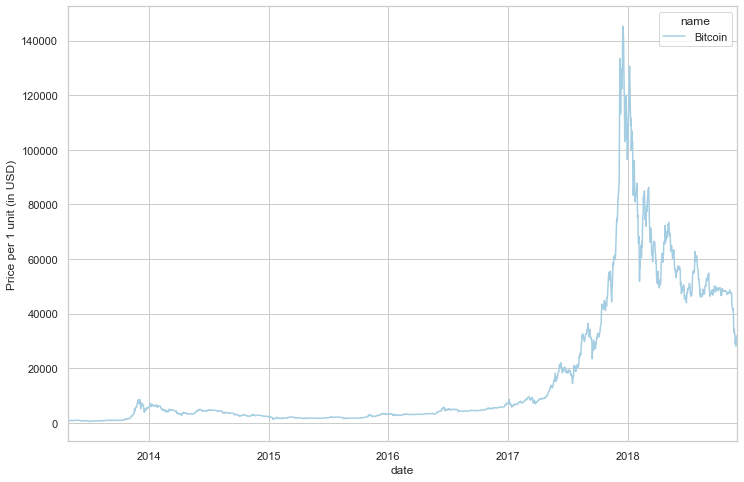

In [20]:
plot_roi(1000, wide_format[["Bitcoin"]])

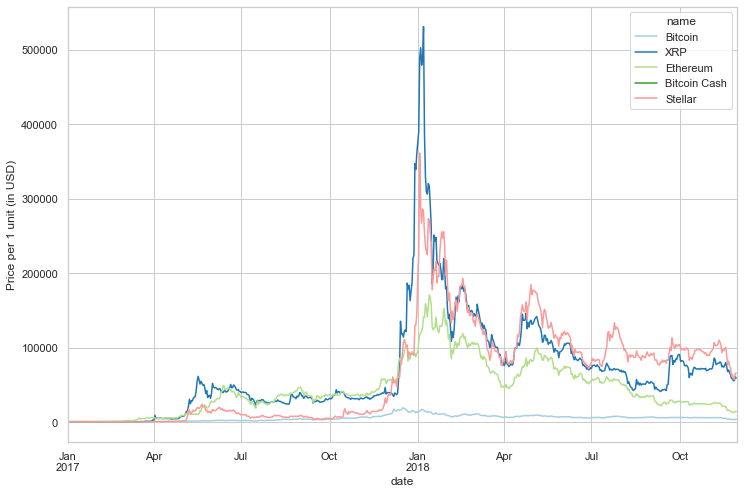

In [21]:
wide_format_2017 = wide_format[(wide_format.index.year >= 2017)]
plot_roi(1000, wide_format_2017[top_5_currency_names])

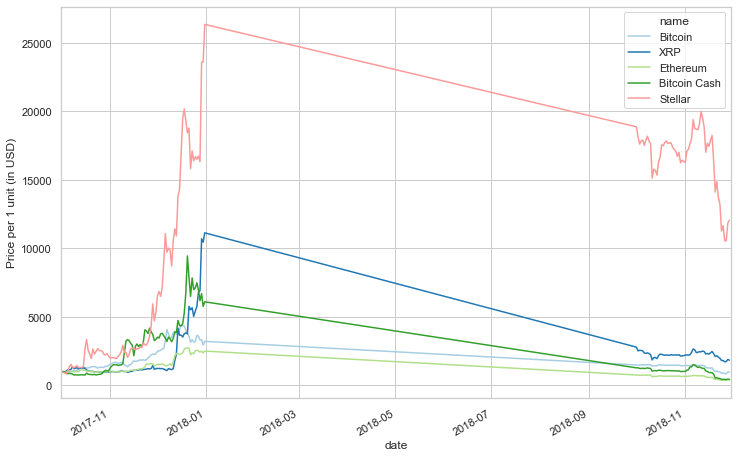

In [22]:
wide_format_late_2017 = wide_format[(wide_format.index.year >= 2017) & (wide_format.index.month >= 10)]
plot_roi(1000, wide_format_late_2017[top_5_currency_names])

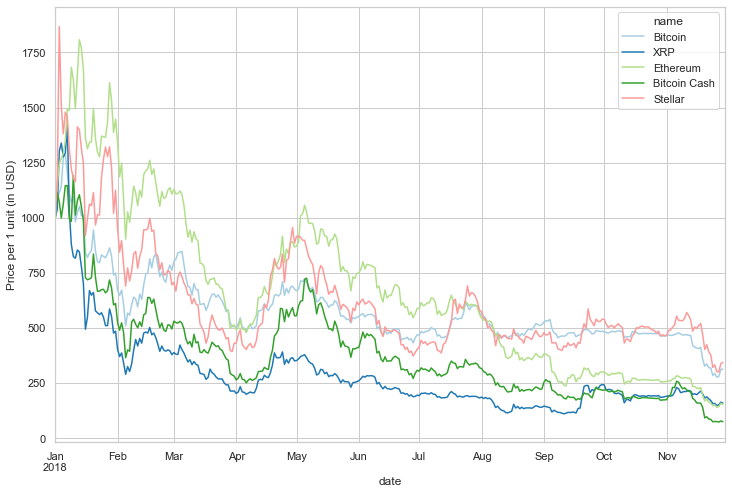

In [23]:
wide_format_2018 = wide_format[(wide_format.index.year >= 2018)]
plot_roi(1000, wide_format_2018[top_5_currency_names])

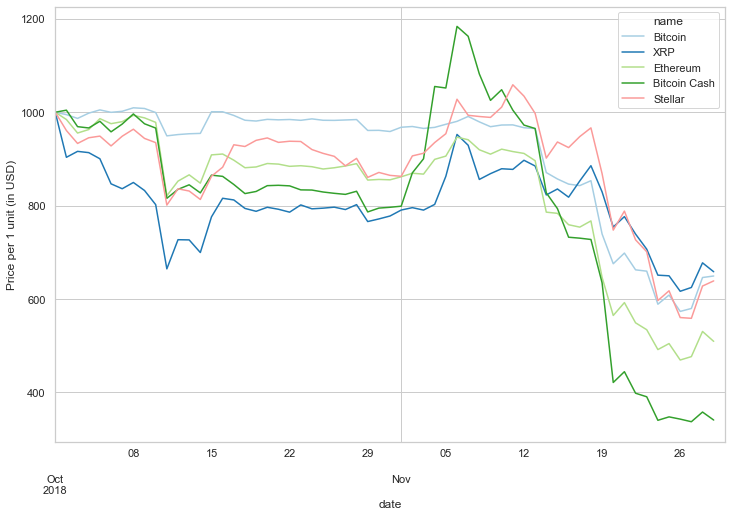

In [24]:
wide_format_late_2018 = wide_format[(wide_format.index.year >= 2018) & (wide_format.index.month >= 10)]
plot_roi(1000, wide_format_late_2018[top_5_currency_names])

In [25]:
btc = data["symbol"] == "BTC"
eth = data["symbol"] == "ETH"
xrp = data["symbol"] == "XRP"

data_my_currencies = data[btc | eth | xrp]

Text(0, 0.5, 'Price per 1 unit (in USD)')

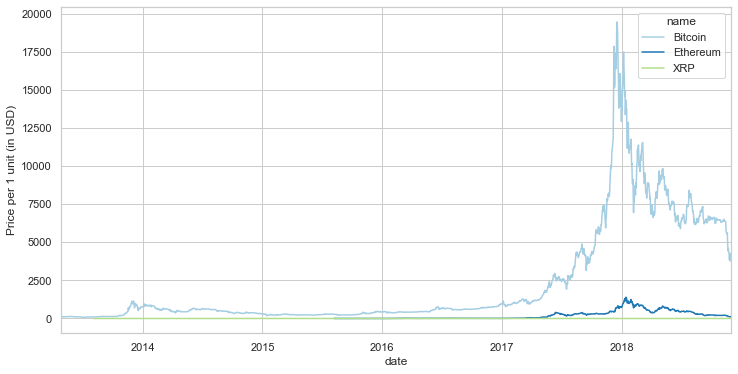

In [26]:
ax = data_my_currencies.groupby(["date", "name"])["close"].mean().unstack().plot();
ax.set_ylabel("Price per 1 unit (in USD)")

Text(17.246875000000003, 0.5, 'Price per 1 unit (in USD)')

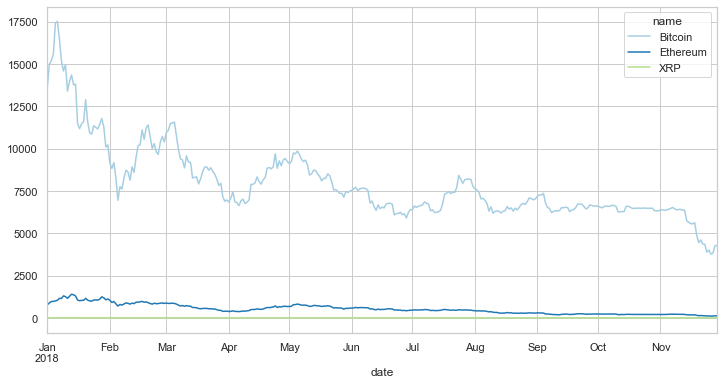

In [27]:
data_my_currencies[data_my_currencies.date.dt.year >= 2018].groupby(["date","name"])["close"].mean().unstack().plot();
ax.set_ylabel("Price per 1 unit (in USD)")

Text(17.246875000000003, 0.5, 'Transaction Volume (in millions)')

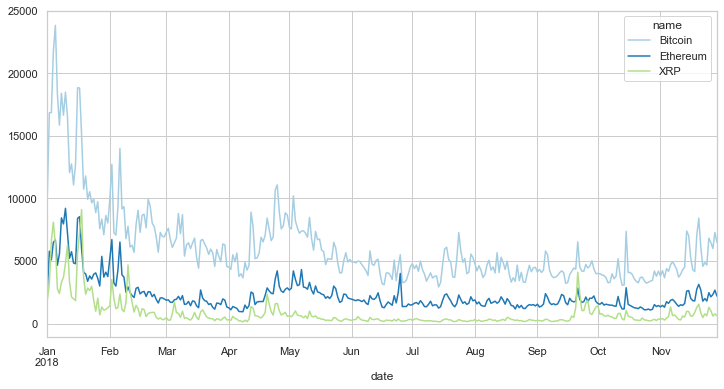

In [28]:
data_my_currencies[data_my_currencies.date.dt.year >= 2018].groupby(["date","name"])["volume_million"].mean().unstack().plot();
ax.set_ylabel("Transaction Volume (in millions)")

In [29]:
def plot_with_textvalue(df):
    ax = df.plot(kind = "bar")
    ax.set_ylabel("Yearly closing prices (in USD)")
    
    for rect in ax.patches:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height, "%d$" % int(height),ha = "center", va = "bottom")

In [30]:
top10Currencies = data.groupby("name")['market_billion'].last().sort_values(ascending = False).head(10)

closing_prices_btc_and_eth = data[btc|eth].groupby(["date","name"])["close"].last().unstack().reset_index()
closing_prices_all = data[data["name"].isin(top10Currencies.index) & ~btc & ~eth].groupby(["date", "name"])["close"].last().unstack().reset_index()

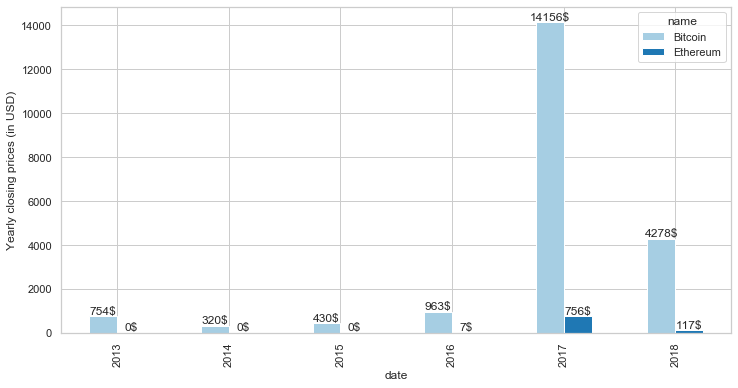

In [31]:
yearly_closing_btc_and_eth = closing_prices_btc_and_eth.groupby(closing_prices_btc_and_eth.date.dt.year).last()
yearly_closing_btc_and_eth.drop(columns = "date", inplace = True)
plot_with_textvalue(yearly_closing_btc_and_eth)

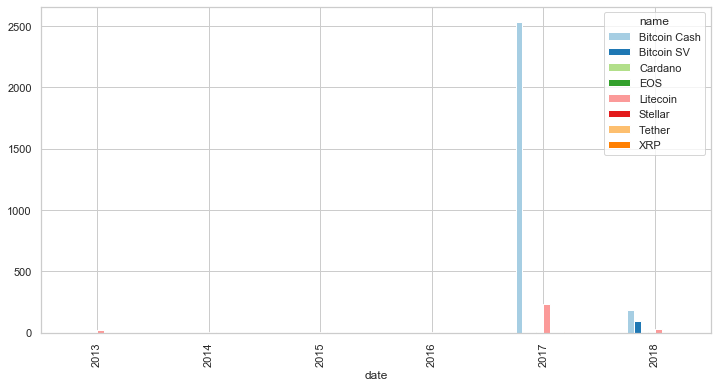

In [32]:
yearly_closing_prices_all = closing_prices_all.groupby(closing_prices_all.date.dt.year).last()
yearly_closing_prices_all.drop(columns = "date", inplace = True)
yearly_closing_prices_all.plot(kind = "bar")

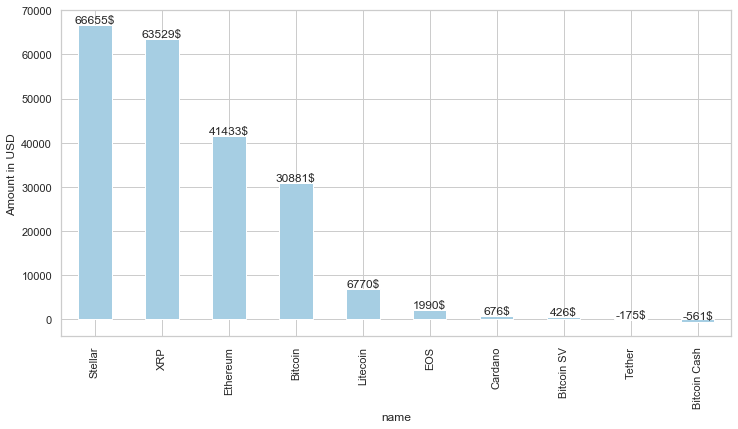

In [33]:
def calc_earnings(purchased,currency_name, df):
    # prints ("Displaying stats for ''currency")
    
    closing_prices = df[(df["name"] == currency_name) & (~df["close"].isnull())]
    closing_prices = closing_prices[["date","close"]]
    
    
    # currency purchased = n
    units_purchased = purchased / closing_prices.iloc[0]["close"]
    
    #print (f"Num. of units purchased: {units_purchased:.1f}")
    
    # current value
    last_price = closing_prices.iloc[-1]["close"]
    #print (f"Last price: {last_price}")
    
    amount_earned = (units_purchased * last_price) - purchased
    
    
    return amount_earned

top_10_currency_earnings = top10Currencies

for currency in top10Currencies.index:
    top_10_currency_earnings[currency] = calc_earnings(1000, currency, data)
    
ax = top_10_currency_earnings.sort_values(ascending = False).plot(kind = "bar")
ax.set_ylabel("Amount in USD")

for rect in ax.patches:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, "%d$" % int(height), ha = "center", va = "bottom")

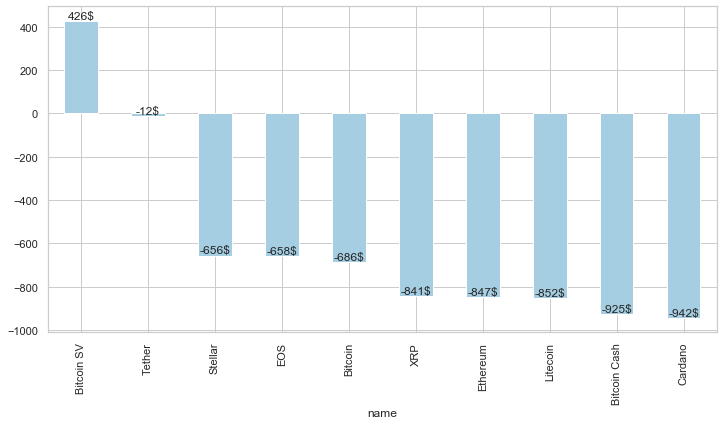

In [34]:
top_10_currencies_earnings_2018 = top10Currencies

for currency in top10Currencies.index:
    top_10_currencies_earnings_2018[currency] = calc_earnings(1000,currency, data[data.date.dt.year >= 2018])
    
top_10_currencies_earnings_2018

ax = top_10_currencies_earnings_2018.sort_values(ascending = False).plot(kind="bar")
for rect in ax.patches:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, "%d$" % int(height), ha = 'center', va = 'bottom')

Text(0.5, 1, 'Correlation Heatmap between Bitcoin and other top 5 Crypto')

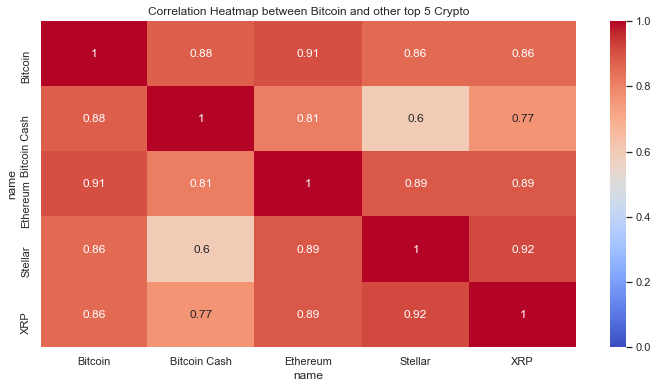

In [35]:
top5Currencies = data.groupby('name')["market_billion"].last().sort_values(ascending=False).head(5)
closing_prices_top5 = data[data["name"].isin(top5Currencies.index)].groupby(["date", "name"])["close"].mean().unstack()

plt.figure(figsize = (12,6))
sns.heatmap(closing_prices_top5.corr(), vmin = 0, vmax = 1, cmap = "coolwarm", annot = True)
plt.title("Correlation Heatmap between Bitcoin and other top 5 Crypto")

In [36]:
data_my_currencies.head()

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread,market_billion,volume_million
0,bitcoin,BTC,Bitcoin,2013-04-28,1,135.30,135.98,132.10,134.21,0.00,1488566728.00,0.54,3.88,1.49,0.00
1,bitcoin,BTC,Bitcoin,2013-04-29,1,134.44,147.49,134.00,144.54,0.00,1603768865.00,0.78,13.49,1.60,0.00
2,bitcoin,BTC,Bitcoin,2013-04-30,1,144.00,146.93,134.05,139.00,0.00,1542813125.00,0.38,12.88,1.54,0.00
3,bitcoin,BTC,Bitcoin,2013-05-01,1,139.00,139.89,107.72,116.99,0.00,1298954594.00,0.29,32.17,1.30,0.00
4,bitcoin,BTC,Bitcoin,2013-05-02,1,116.38,125.60,92.28,105.21,0.00,1168517495.00,0.39,33.32,1.17,0.00


In [37]:
data_my_currencies.drop(columns = ["slug","ranknow","market_billion", "volume_million"]).head()

,symbol,name,date,open,high,low,close,volume,market,close_ratio,spread
0,BTC,Bitcoin,2013-04-28,135.30,135.98,132.10,134.21,0.00,1488566728.00,0.54,3.88
1,BTC,Bitcoin,2013-04-29,134.44,147.49,134.00,144.54,0.00,1603768865.00,0.78,13.49
2,BTC,Bitcoin,2013-04-30,144.00,146.93,134.05,139.00,0.00,1542813125.00,0.38,12.88
3,BTC,Bitcoin,2013-05-01,139.00,139.89,107.72,116.99,0.00,1298954594.00,0.29,32.17
4,BTC,Bitcoin,2013-05-02,116.38,125.60,92.28,105.21,0.00,1168517495.00,0.39,33.32


In [38]:
import numpy as np
import pandas as pd
import os
import random
from sklearn import preprocessing
from collections import deque
import time
import tensorflow as tf
from datetime import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, CuDNNLSTM, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

In [39]:
DIR = "C:/Users/Jackson/Documents/Data Science/CryptoCurrencies/"

SEQ_LEN = 60 # last n days to predict from
FUTURE_PERIOD_PREDICT = 3 # next n days to predict
RATIO_TO_PREDICT = "ETH"
EPOCHS = 10
BATCH_SIZE = 64
NAME = f"{RATIO_TO_PREDICT}-{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"

In [40]:
main_df = data_my_currencies[["symbol","date","open","high","low","close","volume","market","close_ratio","spread"]]

In [41]:
df_btc = main_df.loc[main_df["symbol"]=="BTC"].to_csv (r'crypto_data/BTC.csv', index = False, header=True)
df_eth = main_df.loc[main_df["symbol"]=="ETH"].to_csv (r'crypto_data/ETH.csv', index = False, header=True)
df_xrp = main_df.loc[main_df["symbol"]=="XRP"].to_csv (r'crypto_data/XRP.csv', index = False, header=True)

In [42]:
ratios = ["BTC","ETH","XRP"]
main_df = []

for ratio in ratios:
    dataset = DIR + f"crypto_data/{ratio}.csv"
    
    names = ["date", "symbol","open", "high", "low", "close", "volume", "market", "close_ratio", "spread"]
    df = pd.read_csv(dataset)
    print(df.head())
    
    df.set_index("date", inplace = True)
    #df["market"] = df["market"]/1e9
    #df["volume"] = df["volume"]/1e6
    
    for name in names[1:]:
        df.rename(columns = {name:f"{ratio}_"+name}, inplace = True)
    
    if len(main_df) == 0:
        main_df = df
    else:
        main_df = main_df.join(df)

main_df = main_df.drop(["BTC_symbol","ETH_symbol","XRP_symbol"], axis = 1)

  symbol        date   open   high    low  close  volume        market  \
0    BTC  2013-04-28 135.30 135.98 132.10 134.21    0.00 1488566728.00   
1    BTC  2013-04-29 134.44 147.49 134.00 144.54    0.00 1603768865.00   
2    BTC  2013-04-30 144.00 146.93 134.05 139.00    0.00 1542813125.00   
3    BTC  2013-05-01 139.00 139.89 107.72 116.99    0.00 1298954594.00   
4    BTC  2013-05-02 116.38 125.60  92.28 105.21    0.00 1168517495.00   

   close_ratio  spread  
0         0.54    3.88  
1         0.78   13.49  
2         0.38   12.88  
3         0.29   32.17  
4         0.39   33.32  
  symbol        date  open  high  low  close     volume       market  \
0    ETH  2015-08-07  2.83  3.54 2.52   2.77  164329.00 166610555.00   
1    ETH  2015-08-08  2.79  2.80 0.71   0.75  674188.00  45486894.00   
2    ETH  2015-08-09  0.71  0.88 0.63   0.70  532170.00  42399573.00   
3    ETH  2015-08-10  0.71  0.73 0.64   0.71  405283.00  42818364.00   
4    ETH  2015-08-11  0.71  1.13 0.66   1.07 

In [43]:
#define criteria 

def classify(current, future):
    if float(future) > float(current):
        return 1
    else:
        return 0

def preprocess(df):
    df = df.drop("future", 1)

    for col in df.columns:
        if col != "target":
            df[col] = df[col].pct_change()
            df.dropna(inplace=True)
            #df[col] = preprocessing.scale(df[col].values)
    
    df.dropna(inplace=True)

    sequential_data = []
    prev_days = deque(maxlen=SEQ_LEN)
    
    for i in df.values:
        prev_days.append([n for n in i[:-1]])
        if len(prev_days) == SEQ_LEN:
            sequential_data.append([np.array(prev_days), i[-1]])
    
    random.shuffle(sequential_data)       

    buys = []
    sells = []

    for seq, target in sequential_data:
        if target == 0:
            sells.append([seq, target])
        elif target == 1:
            buys.append([seq, target])
    
    random.shuffle(buys)
    random.shuffle(sells)

    lower = min(len(buys), len(sells))
 
    buys = buys[:lower]
    sells = sells[:lower]

    sequential_data = buys + sells
    random.shuffle(sequential_data)

    X = []
    y = []
    
    for seq, target in sequential_data:
        X.append(seq)
        y.append(target)
    
    return np.array(X),y  

In [44]:
main_df["future"] = main_df[f"{RATIO_TO_PREDICT}_close"].shift(-FUTURE_PERIOD_PREDICT)
main_df["target"] = list(map(classify, main_df[f"{RATIO_TO_PREDICT}_close"], main_df["future"]))

#print(main_df[[f"{RATIO_TO_PREDICT}_close", "future", "target"]].head(10))

In [45]:
main_df.head()

,BTC_open,BTC_high,BTC_low,BTC_close,BTC_volume,BTC_market,BTC_close_ratio,BTC_spread,ETH_open,ETH_high,...,XRP_open,XRP_high,XRP_low,XRP_close,XRP_volume,XRP_market,XRP_close_ratio,XRP_spread,future,target
date,,,,,,,,,,,,,,,,,,,,,
2013-04-28,135.30,135.98,132.10,134.21,0.00,1488566728.00,0.54,3.88,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,0
2013-04-29,134.44,147.49,134.00,144.54,0.00,1603768865.00,0.78,13.49,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,0
2013-04-30,144.00,146.93,134.05,139.00,0.00,1542813125.00,0.38,12.88,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,0
2013-05-01,139.00,139.89,107.72,116.99,0.00,1298954594.00,0.29,32.17,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,0
2013-05-02,116.38,125.60,92.28,105.21,0.00,1168517495.00,0.39,33.32,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,0


In [46]:
dates = sorted(main_df.index.values)
minutes = []
for date in dates:
    dt = datetime.strptime(date, "%Y-%m-%d").date()
    s = time.mktime(dt.timetuple())
    minutes.append(int(s/360))

main_df["time"] = minutes
main_df.set_index(["time"], inplace = True)

last_5pct = minutes[-int(len(minutes)*0.05)]
print(last_5pct)

4263160


In [47]:
validation_main_df = main_df[(main_df.index >= last_5pct)]
main_df = main_df[(main_df.index < last_5pct)]
main_df.replace([np.inf, -np.inf], np.nan)

main_df = main_df.dropna(0)

In [48]:
train_x, train_y = preprocess(main_df)
validation_x, validation_y = preprocess(validation_main_df)

In [49]:
print(f"train data: {len(train_x)} validation: {len(validation_x)}")
print(f"Don't buys: {train_y.count(0)}, buys: {train_y.count(1)}")
print(f"VALIDATION Dont buys: {validation_y.count(0)}, buys: {validation_y.count(1)}")

train data: 416 validation: 4
Don't buys: 208, buys: 208
VALIDATION Dont buys: 2, buys: 2


In [50]:
model = Sequential()
model.add(CuDNNLSTM(128, input_shape = (train_x.shape[1:]), return_sequences = True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(CuDNNLSTM(128,return_sequences = True))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(CuDNNLSTM(128))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation = "relu"))
model.add(Dropout(0.2))

model.add(Dense(2, activation = "softmax"))

opt = tf.keras.optimizers.Adam(lr = 0.001, decay = 1e-6)

model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = opt,
              metrics = ["accuracy"])

logdir = os.path.join("logs",NAME,)

tensorboard = TensorBoard(log_dir = logdir)
filepath = "RNN_Final-{epoch:02d}-{val_acc:.3f}" # unique file name that will include the epoch and validation acc
#monitor = EarlyStopping(monitor="val_loss", min_delta=1e3, patience = 5, verbose = 1, mode = "auto")
checkpoint = ModelCheckpoint(os.path.join(DIR,"models/{}.hdf5",).format(filepath, monitor = "val_acc" ,verbose = 1, save_best_only = True, mode = "max"))

model.fit(
    train_x, train_y,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (validation_x, validation_y),
    callbacks = [tensorboard, checkpoint]
)

W0626 17:10:17.822424  5908 deprecation.py:506] From C:\Users\Jackson\Anaconda2\envs\tensorflow\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Train on 416 samples, validate on 4 samples
Epoch 1/10
416/416 [==============================] - 4s 9ms/sample - loss: 0.6932 - acc: 0.4760 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 2/10
416/416 [==============================] - 0s 876us/sample - loss: 0.6932 - acc: 0.5048 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 3/10
416/416 [==============================] - 0s 853us/sample - loss: 0.6932 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 4/10
416/416 [==============================] - 0s 857us/sample - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 5/10
416/416 [==============================] - 0s 866us/sample - loss: 0.6932 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 6/10
416/416 [==============================] - 0s 848us/sample - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 7/10
416/416 [==============================] - 0s 869us/sample - loss: 0.6932 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 